
# Table of Contents
1. [Introduction](#Introduction)
   
2. [Data Preparation](#Data-Preparation)

   2.1 [ST prepration](##ST-prepration)
   
   2.2 [WES prepration](##WES-prepration)
   
3. [Tumoroscope](#Tumoroscope)

   3.1 [OS Requirements](#OS-Requirements)
   
   3.2 [Python Dependencies](#Python-Dependencies)
   
   3.3 [Install from PyPi](#Install-from-PyPi)
   
   3.4 [Example of using Tumoroscope](#Example-of-using-Tumoroscope)
   
4. [Validation](#Validation)


# Introduction

In this vignette, we provide a hands-on walkthrough of using the Tumoroscope model to analyze cancer sequencing data. We start with an overview of loading and processing raw sequencing data. We then cover the key parameters and usage of the Tumoroscope model for clone mapping. Finally, we demonstrate tools for visualizing and interpreting the subclonal populations predicted by Tumoroscope.

This vignette aims to make the Tumoroscope workflow accessible to cancer researchers interested in studying clonal dynamics. Working through the examples will build intuition for how Tumoroscope integrates spatial transcriptomics, bulk sequencing data and H&E images into a high-resolution map of intratumor heterogeneity. The provided code serves as a starting point for researchers to apply Tumoroscope to their own cancer genomics datasets.

# Data-Preparation

## ST-prepration

We utilized the st_pipeline available at https://github.com/jfnavarro/st_pipeline to process our raw Spatial Transcriptomics sequencing data. We recommend users apply the st_pipeline to their ST FASTQ files before proceeding with further analysis. For this study, we used the BAM files that are an interim output, but are needed specifically for mutation calling before running Tumoroscope. 

The ST pipeline begins by building a genome index using STAR. This index will be used to align the sequencing reads to the reference genome. We specify parameters like the path to the reference FASTA genome file, the GTF annotation file, and the overhang length.

```
STAR --runThreadN 10 \
--runMode genomeGenerate \
--genomeDir output \
--genomeFastaFiles /home/shafighi/star/fasta/GRCh38.primary_assembly.genome.fa \
--sjdbGTFfile /home/shafighi/star/gtcf/gencode.v35.annotation.gtf \
--sjdbOverhang 99
```

The basic command for running the pipeline is:

```
st_pipeline_run.py --expName test \
                --ids /home/shafighi/alireza/stpipeline/index/1000L9_barcodes.txt \
                --ref-map /home/shafighi/alireza/stpipeline/star/ 
                --log-file log_file.txt \
                --output-folder /home/shafighi/alireza/stpipeline/output /home/shafighi/alireza/stpipeline/fasta/EGAR00001746265_Patient1_2.4_R1.fastq /home/shafighi/alireza/stpipeline/fasta/EGAR00001746265_Patient1_2.4_R2.fastq 
                --transcriptome --no-clean-up --temp-folder /home/shafighi/alireza/stpipeline/tmp
```
    

See the st_pipeline GitHub repository for details on all the available parameters and customization options. Specifically, you need ST barcodes and the directory of the STAR results. We used "--no-clean-up" parameter to have the BAM files as outputs.  

### Calling mutations from ST BAM files 

Since standard mutation callers cannot be directly applied to Spatial Transcriptomics BAM files, we developed a custom tool called read_counter (https://github.com/shafighi/read_counter) to identify mutation alleles for input to Tumoroscope.  

```python st_read_counter.py st_bam_file  st_bai_file  barcode  vcf_file  output_name  tumor_column_vcf st_dir```

The `st_read_counter.py` script is designed to streamline the process of analyzing Spatial Transcriptomics (ST) data to get the allelic read counts. It requires several input files and parameters to operate effectively:

1. `st_bam_file` and `st_bai_file`: These are the BAM and BAI files containing the ST data.

2. `barcode`: This parameter represents the barcode or identifier associated with the st sample, which is crucial for identifying and distinguishing the position of the data points.

3. `vcf_file`: The VCF (Variant Call Format) file contains information about selected mutations from Whole Exome Sequencing (WES). 

4. `output_name`: The name of the output file.

5. `tumor_column_vcf`: This specifies the column in the VCF file that corresponds to the sample.

6. `st_dir`: This parameter defines the directory where the program will generate the necessary output files.

The script's primary function is to process the provided ST BAM files, integrate them with the relevant VCF data, and generate allele counts for each potential variant site. These allele counts serve as essential inputs for downstream analysis tools like Tumoroscope, enabling the inference of subclonal populations across the spatial spots.

To gain comprehensive usage details and further insights into the functionality of `st_read_counter.py`, please refer to the `read_counter` repository and associated documentation.

## WES-prepration

### Applying FalconX and Canopy 

We utilized Canopy (https://github.com/yuchaojiang/Canopy) to infer subclones from the mutation calls. Canopy takes the mutation alleles files along with copy number segments as input. To obtain copy number, we used FalconX as described in the Canopy repository (https://github.com/yuchaojiang/Canopy/blob/master/instruction/SNA_CNA_input.md). FalconX segments the genome based on read depth and outputs copy number calls for each segment. With the mutation VCFs and copy number segments, Canopy constructs a clonal tree using a Bayesian nonparametric mixture model. It outputs the tree structure, genotype, and frequency of the clones. Consult the Canopy documentation for full usage details. 

# Tumoroscope

### OS Requirements
The package has been tested on the following systems:
+ macOS (ventura 13.0 and Catalina 10.15.7)
+ Linux (ubuntu 14.04)

### Python Dependencies
`tumoroscope` mainly depends on the Python scientific stack.

```
numpy
pandas
matplotlib
seaborn
pickle5
scipy
```

### Install from PyPi
Once you've successfully installed all the necessary libraries, installing Tumoroscope is a straightforward process. Simply execute the following command:

```
pip3 install tumoroscope
```

### Example of using Tumoroscope

To get started, it's essential to import the required packages.

In [1]:
from tumoroscope.run_tumoroscope import run_tumoroscope
from tumoroscope.simulation import simulation as sim
from tumoroscope.visualization import visualization as vis
from tumoroscope.tumoroscope import tumoroscope as tum
from tumoroscope import constants
import pickle
import numpy as np
import random
from multiprocessing import Pool
import time
import json
import re
import pandas as pd
import glob, os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

Next, you'll proceed to parameter initialization. It's crucial to configure key settings such as the "config_file," visualization preferences, and the output folder. Additionally, you'll need to specify the available number of cores and determine the desired number of chains for running Tumoroscope efficiently.

In [2]:
%%time
pi_2D = True
th = 0.8 # threshhold for Z
constants.VISUALIZATION = 'visualization'
constants.CHAINS = 1
constants.CORES = 35
every_n_sample = 5
l=1
changes_batch= 500
constants.RESULTS = 'Result_demo'
number = '1'
config_file =  '../configs/simulation_demo.json'
result_txt = constants.RESULTS+'/results_'
optimal_rate = 0.40
test = constants.RESULTS
begin= time.time()

CPU times: user 471 µs, sys: 312 µs, total: 783 µs
Wall time: 687 µs


Then, we create the output directory. 

In [3]:
if not os.path.exists(constants.RESULTS):
    os.makedirs(constants.RESULTS)
    print("Directory ", constants.RESULTS, " Created ")
else:
    print("Directory ", constants.RESULTS, " already exists")

Directory  Result_demo  already exists


Afterwards, we read the config file to set the parameters of the model. 

In [4]:
file_name = re.split("/|.json",config_file)[2]
vis_1 = vis(constants.RESULTS + '/n_var_' + file_name + '_' + constants.VISUALIZATION)
with open(config_file) as json_data_file:
    data = json.load(json_data_file)

Directory  Result_demo/n_var_simulation_demo_visualization  already exists


Here are the parameters that we need to specify in the config file. K, S and I are specifying the number of clones, number of spots and the number of mutations that we are using. 

In [5]:
K = data['structure']['K']
S = data['structure']['S']
I = data['structure']['I']

Please set theta to 1 and p_c_binom to null. These are regarding to some features that we are not supporting at the moment. 

In [6]:
theta = data['structure']['theta']
p_c_binom = data['C_variation']['p_c_binom']

In the next part we are setting the  genotype by setting different pattern to "C" and the number of repetition of these patterns to "repeat". 

In [7]:
C_temp = data['C_variation']['C']
repeat_temp = data['C_variation']['repeat']
if C_temp is None:
    C = None
else:
    C_t = []
    for ct in range(len(C_temp)):
        C_t.append(np.tile(C_temp[ct], (repeat_temp[ct], 1)))
    C = np.concatenate(C_t)

In the n_variation section, we should specify if we are sampling n or not by setting n_sampling to true or false. n_lamda should be set to the expected number of cells in a spot and n should be set to the observed number of cells in the spots. 

In [8]:
n_sampling = data['n_variation']['n_sampling']
n_lambda = np.tile(data['n_variation']['n_lambda'], (S))

if data['n_variation']['n'] is not None:
    n = np.array(data['n_variation']['n'])
else:
    n = None

It's essential to define the "average_clone_in_spot" parameter, which represents your anticipated average number of clones within each spot. This estimation should be grounded in your understanding of the sample characteristics and the level of heterogeneity you anticipate. Please set Z to null. This parameter is not supported yet.

In [9]:
Z = data['Z_variation']['Z']
avarage_clone_in_spot = data['Z_variation']['avarage_clone_in_spot']


Then we need to set the parameters regarding the sampling. 

In [12]:
max_iter = int(data['smapling']['max_iter'])
min_iter = int(data['smapling']['min_iter'])
burn_in = int(data['smapling']['burn_in'])
batch = int(data['smapling']['batch'])
var_calculation = int(data['smapling']['min_iter']*0.9)

Within this segment, you have the flexibility to define variables relating to read counts and clone frequencies. It's noteworthy that parameters lacking the "_selected" suffix pertain to the actual values, whereas those with the "_selected" suffix correspond to user-provided estimates. This distinction arises from the fact that, in actual datasets, true values are often elusive, necessitating user approximations. As such, distinct parameters cater to both real data and user-inferred estimates.

In [13]:
phi_gamma = np.array(data['Gamma']['phi_gamma'])
        # F could be None, In that case, it will be generated using dirichlet distribution
F_epsilon = np.tile(data['Gamma']['F_epsilon'], (K, 1))
F_fraction =  data['Gamma']['F_fraction']

F = np.tile(data['Gamma']['F'], (K, 1))  # np.array([[9,2],[9,2],[9,2],[9,2],[9,2],[9,2]])
phi_gamma_selected = np.array(data['Gamma']['phi_gamma_selected'])

F_epsilon_selected = np.tile(data['Gamma']['F_epsilon_selected'], (K, 1))
F_selected = np.tile(data['Gamma']['F_selected'], (K, 1))

  # np.array([[9,2],[9,2],[9,2],[9,2],[9,2],[9,2]])
gamma = data['theta']['gamma']
gamma_sampling = data['theta']['gamma_sampling']
theta_variable = data['theta']['theta_variable']

In the next step, we generate the simulated data using sim function that we imported before.


In [14]:
sample_1 = sim(K=K,S=S,r=phi_gamma[0],p=phi_gamma[1],I=I,F=F,D=None,A=None,C=C,avarage_clone_in_spot=avarage_clone_in_spot,random_seed=random.randint(1,100),F_epsilon= F_epsilon,n=n,p_c_binom=p_c_binom,theta=theta,Z = Z,n_lambda=n_lambda,F_fraction=F_fraction,theta_variable=theta_variable,gamma=gamma, pi_2D=pi_2D)


simulation finished


At this stage, we introduce noise into the dataset, with the noise intensity contingent upon the mean value of the Poisson distribution. This mean value is modulated by user-defined noise parameters, affording precise control over the noise level.

In [15]:
noise = '1'
if noise=='0':
    n_lambda_tum = sample_1.n
else:
    b = np.random.binomial(n=1,p=0.5,size=S)
    noise_pois = np.random.poisson(lam=int(noise),size=S)
    n_lambda_tum = sample_1.n+noise_pois*b+noise_pois*(b-1)
    n_lambda_tum[n_lambda_tum<1]=1


In the next step, we use Tumoroscope to infer the clones in the spots.

In [16]:
tum_obj=(tum(name = constants.RESULTS +'/'+ file_name+'_chain_'+str(constants.CHAINS),K=sample_1.K,S=sample_1.S,r=phi_gamma_selected[0],p=phi_gamma_selected[1],I=sample_1.I,avarage_clone_in_spot=sample_1.avarage_clone_in_spot,F = F_selected,C = sample_1.C,A = sample_1.A,D = sample_1.D,F_epsilon=F_epsilon_selected,optimal_rate=optimal_rate,n_lambda = n_lambda_tum,gamma = gamma_sampling, pi_2D=pi_2D,result_txt=result_txt+file_name+'.txt'))
tum_obj.gibbs_sampling(seed = random.randint(1,100) ,min_iter=min_iter,max_iter = max_iter,burn_in=burn_in, batch = batch,simulated_data= sample_1,n_sampling=True,F_fraction=F_fraction,theta_variable = theta_variable, pi_2D=pi_2D,th=th,every_n_sample=every_n_sample,changes_batch=changes_batch,var_calculation=var_calculation)

simulation finished
Batch 0 finished with [62.5  67.5  53.33 55.83 45.83 65.83]% convergence for [0,10,20,30,40,50]% burn-in.
Batch 1 finished with [85.83 72.5  56.67 61.67 59.17 62.5 ]% convergence for [0,10,20,30,40,50]% burn-in.
Batch 2 finished with [93.33 60.   60.   51.67 46.67 47.5 ]% convergence for [0,10,20,30,40,50]% burn-in.
Batch 3 finished with [96.67 63.33 52.5  50.83 50.   60.  ]% convergence for [0,10,20,30,40,50]% burn-in.
Batch 4 finished with [98.33 59.17 54.17 46.67 48.33 45.  ]% convergence for [0,10,20,30,40,50]% burn-in.
Batch 5 finished with [98.33 55.   47.5  42.5  44.17 55.83]% convergence for [0,10,20,30,40,50]% burn-in.
Batch 6 finished with [99.17 55.   49.17 55.   59.17 58.33]% convergence for [0,10,20,30,40,50]% burn-in.
Batch 7 finished with [99.17 60.83 54.17 56.67 70.83 60.83]% convergence for [0,10,20,30,40,50]% burn-in.
Batch 8 finished with [99.17 62.5  65.   67.5  70.83 62.5 ]% convergence for [0,10,20,30,40,50]% burn-in.
Batch 9 finished with [100

# Validation

We're creating a chart that compares the actual clones present in each spot with the clones we've estimated. This helps us confirm how well our estimates match the real data.

Text(0.5, 1.0, 'Mean Average Error (MAE): 0.0069')

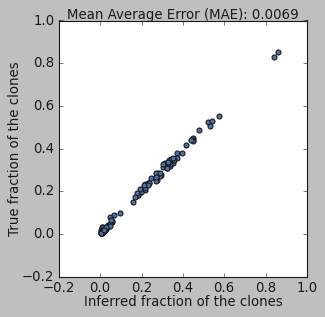

In [17]:
mpl.style.use('classic')
font_size=12
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(tum_obj.inferred_H.tolist(),sample_1.H.tolist())
ax.set_ylabel('True fraction of the clones', fontsize=font_size,labelpad=0.05)
ax.set_xlabel('Inferred fraction of the clones', fontsize=font_size,labelpad=0.05)
ax.set_title('Mean Average Error (MAE): '+str(round(tum_obj.H_SEE,4)),fontsize=font_size, pad = 1.5)